In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchaudio
import sys

import matplotlib.pyplot as plt
import IPython.display as ipd

from tqdm import tqdm


from torchaudio.datasets import SPEECHCOMMANDS
import os

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# DataSet creation

In [4]:
class SubsetSC(SPEECHCOMMANDS):
    def __init__(self, subset: str = None):
        super().__init__("./", download=True)

        def load_list(filename):
            filepath = os.path.join(self._path, filename)
            with open(filepath) as fileobj:
                return [os.path.normpath(os.path.join(self._path, line.strip())) for line in fileobj]

        if subset == "validation":
            self._walker = load_list("validation_list.txt")
        elif subset == "testing":
            self._walker = load_list("testing_list.txt")
        elif subset == "training":
            excludes = load_list("validation_list.txt") + load_list("testing_list.txt")
            excludes = set(excludes)
            self._walker = [w for w in self._walker if w not in excludes]

## Create training and testing split of the data. We do not use validation in this tutorial.

In [5]:
train_set = SubsetSC("training")
test_set = SubsetSC("testing")

In [6]:
def cut_dataset(dataset, labels):
    items_to_remove = []
    for i, (_, _, label, *_) in enumerate(dataset):
        if label not in labels:
            items_to_remove.append(i)

    for elem in sorted(items_to_remove, reverse=True):
        dataset._walker.pop(elem)

In [7]:
commands = ["forward", "backward", "left", "right", "stop", "on", "off"]

In [8]:
cut_dataset(train_set, commands)
cut_dataset(test_set, commands)

Shape of waveform: torch.Size([1, 16000])
Sample rate of waveform: 16000


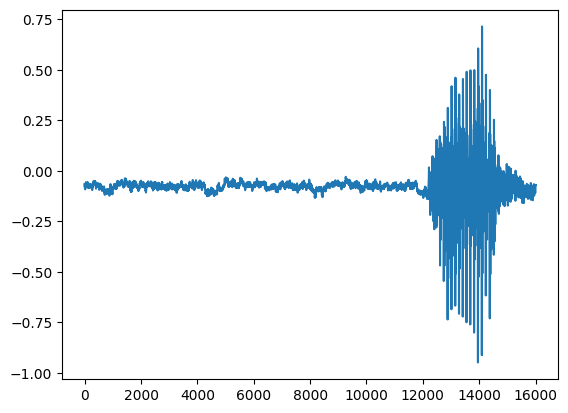

In [126]:
waveform, sample_rate, label, speaker_id, utterance_number = train_set[0]
print("Shape of waveform: {}".format(waveform.size()))
print("Sample rate of waveform: {}".format(sample_rate))
plt.plot(waveform.t().numpy());

In [10]:
labels = sorted(list(set(datapoint[2] for datapoint in train_set)))
labels

['backward', 'forward', 'left', 'off', 'on', 'right', 'stop']

In [11]:
waveform_second, *_ = train_set[1]
ipd.Audio(waveform_second.numpy(), rate=sample_rate)

In [78]:
new_sample_rate = 8000
transform = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=new_sample_rate)
transformed = transform(waveform_second)

ipd.Audio(transformed.numpy(), rate=new_sample_rate)

In [79]:
transformed.shape

torch.Size([1, 8000])

In [55]:
def label_to_index(word):
    # Return the position of the word in labels
    return torch.tensor(labels.index(word))


def index_to_label(index):
    # Return the word corresponding to the index in labels
    # This is the inverse of label_to_index
    return labels[index]


word_start = "forward"
index = label_to_index(word_start)
word_recovered = index_to_label(index)

print(word_start, "-->", index, "-->", word_recovered)

forward --> tensor(1) --> forward


In [56]:
def pad_sequence(batch):
    # Make all tensor in a batch the same length by padding with zeros
    batch = [item.t() for item in batch]
    batch = torch.nn.utils.rnn.pad_sequence(batch, batch_first=True, padding_value=0.)
    return batch.permute(0, 2, 1)


def collate_fn(batch):

    # A data tuple has the form:
    # waveform, sample_rate, label, speaker_id, utterance_number

    tensors, targets = [], []

    # Gather in lists, and encode labels as indices
    for waveform, _, label, *_ in batch:
        tensors += [waveform]
        targets += [label_to_index(label)]

    # Group the list of tensors into a batched tensor
    tensors = pad_sequence(tensors)
    targets = torch.stack(targets)

    return tensors, targets


batch_size = 256

if device == "cuda":
    num_workers = 1
    pin_memory = True
else:
    num_workers = 0
    pin_memory = False

train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)
test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)

In [130]:
next(iter(train_loader))[0].shape

torch.Size([256, 1, 16000])

# Define the Network

In [84]:
class M5(nn.Module):
    def __init__(self, n_input=1, n_output=35, stride=16, n_channel=32):
        super().__init__()
        self.conv1 = nn.Conv1d(n_input, n_channel, kernel_size=25, stride=stride)
        self.bn1 = nn.BatchNorm1d(n_channel)
        self.pool1 = nn.MaxPool1d(4)
        self.conv2 = nn.Conv1d(n_channel, n_channel, kernel_size=3)
        self.bn2 = nn.BatchNorm1d(n_channel)
        self.pool2 = nn.MaxPool1d(4)
        self.conv3 = nn.Conv1d(n_channel, 2 * n_channel, kernel_size=3)
        self.bn3 = nn.BatchNorm1d(2 * n_channel)
        self.pool3 = nn.MaxPool1d(4)
        self.conv4 = nn.Conv1d(2 * n_channel, 2 * n_channel, kernel_size=3)
        self.bn4 = nn.BatchNorm1d(2 * n_channel)
        self.pool4 = nn.MaxPool1d(4)
        self.fc1 = nn.Linear(2 * n_channel, n_output)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = self.pool1(x)
        x = self.conv2(x)
        x = F.relu(self.bn2(x))
        x = self.pool2(x)
        x = self.conv3(x)
        x = F.relu(self.bn3(x))
        x = self.pool3(x)
        x = self.conv4(x)
        x = F.relu(self.bn4(x))
        x = self.pool4(x)
        x = F.avg_pool1d(x, x.shape[-1])
        x = x.permute(0, 2, 1)
        x = self.fc1(x)
        return F.log_softmax(x, dim=2)


model = M5(n_input=transformed.shape[0], n_output=len(labels))
model.to(device)
print(model)


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


n = count_parameters(model)
print("Number of parameters: %s" % n)

M5(
  (conv1): Conv1d(1, 32, kernel_size=(25,), stride=(16,))
  (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(32, 32, kernel_size=(3,), stride=(1,))
  (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv1d(32, 64, kernel_size=(3,), stride=(1,))
  (bn3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv1d(64, 64, kernel_size=(3,), stride=(1,))
  (bn4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool4): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=64, out_features=7, bias=True)
)
Number

In [85]:
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)  # reduce the learning after 20 epochs by a factor of 10

# Training and Testing the Network

In [86]:
def train(model, epoch, log_interval):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):

        data = data.to(device)
        target = target.to(device)

        # apply transform and model on whole batch directly on device
        data = transform(data)
        output = model(data)

        # negative log-likelihood for a tensor of size (batch x 1 x n_output)
        loss = F.nll_loss(output.squeeze(), target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # print training stats
        if batch_idx % log_interval == 0:
            print(f"Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}")

        # update progress bar
        pbar.update(pbar_update)
        # record loss
        losses.append(loss.item())

def number_of_correct(pred, target):
    # count number of correct predictions
    return pred.squeeze().eq(target).sum().item()


def get_likely_index(tensor):
    # find most likely label index for each element in the batch
    return tensor.argmax(dim=-1)


def test(model, epoch):
    model.eval()
    correct = 0
    for data, target in test_loader:

        data = data.to(device)
        target = target.to(device)

        # apply transform and model on whole batch directly on device
        data = transform(data)
        output = model(data)

        pred = get_likely_index(output)
        correct += number_of_correct(pred, target)

        # update progress bar
        pbar.update(pbar_update)

    print(f"\nTest Epoch: {epoch}\tAccuracy: {correct}/{len(test_loader.dataset)} ({100. * correct / len(test_loader.dataset):.0f}%)\n")

  0%|          | 0.09999999999999999/100 [00:00<09:04,  5.45s/it]

Train Epoch: 1 [0/17825 (0%)]	Loss: 2.298386


  0%|          | 0.4000000000000002/100 [00:01<03:07,  1.88s/it] 

Train Epoch: 1 [5120/17825 (29%)]	Loss: 1.348365


  1%|          | 0.6249999999999998/100 [00:01<02:37,  1.58s/it] 

Train Epoch: 1 [10240/17825 (57%)]	Loss: 0.849036


  1%|          | 0.849999999999999/100 [00:01<02:28,  1.50s/it] 

Train Epoch: 1 [15360/17825 (86%)]	Loss: 0.748395


  1%|          | 0.9249999999999987/100 [00:02<04:48,  2.91s/it]


Test Epoch: 1	Accuracy: 1797/2337 (77%)



  1%|          | 1.0124999999999984/100 [00:02<04:37,  2.81s/it]

Train Epoch: 2 [0/17825 (0%)]	Loss: 0.606790


  1%|▏         | 1.387499999999997/100 [00:03<02:46,  1.69s/it] 

Train Epoch: 2 [5120/17825 (29%)]	Loss: 0.495684


  2%|▏         | 1.6124999999999963/100 [00:03<02:31,  1.54s/it]

Train Epoch: 2 [10240/17825 (57%)]	Loss: 0.547839


  2%|▏         | 1.8499999999999954/100 [00:03<02:25,  1.49s/it]

Train Epoch: 2 [15360/17825 (86%)]	Loss: 0.574872


  2%|▏         | 1.9249999999999952/100 [00:03<02:55,  1.79s/it]


Test Epoch: 2	Accuracy: 1959/2337 (84%)



  2%|▏         | 2.012499999999995/100 [00:04<03:16,  2.01s/it] 

Train Epoch: 3 [0/17825 (0%)]	Loss: 0.395806


  2%|▏         | 2.4000000000000004/100 [00:04<02:30,  1.55s/it]

Train Epoch: 3 [5120/17825 (29%)]	Loss: 0.385145


  3%|▎         | 2.6250000000000036/100 [00:04<02:24,  1.49s/it]

Train Epoch: 3 [10240/17825 (57%)]	Loss: 0.473874


  3%|▎         | 2.8500000000000068/100 [00:05<02:23,  1.47s/it]

Train Epoch: 3 [15360/17825 (86%)]	Loss: 0.328572


  3%|▎         | 2.925000000000008/100 [00:05<02:52,  1.78s/it] 


Test Epoch: 3	Accuracy: 2027/2337 (87%)



  3%|▎         | 3.012500000000009/100 [00:05<03:16,  2.02s/it]

Train Epoch: 4 [0/17825 (0%)]	Loss: 0.297332


  3%|▎         | 3.4000000000000146/100 [00:06<02:29,  1.55s/it]

Train Epoch: 4 [5120/17825 (29%)]	Loss: 0.334294


  4%|▎         | 3.6250000000000178/100 [00:06<02:23,  1.49s/it]

Train Epoch: 4 [10240/17825 (57%)]	Loss: 0.259191


  4%|▍         | 3.850000000000021/100 [00:06<02:21,  1.48s/it] 

Train Epoch: 4 [15360/17825 (86%)]	Loss: 0.301840


  4%|▍         | 3.925000000000022/100 [00:07<02:54,  1.82s/it]


Test Epoch: 4	Accuracy: 2047/2337 (88%)



  4%|▍         | 4.012500000000023/100 [00:07<03:12,  2.01s/it]

Train Epoch: 5 [0/17825 (0%)]	Loss: 0.254112


  4%|▍         | 4.375000000000028/100 [00:07<02:32,  1.59s/it]

Train Epoch: 5 [5120/17825 (29%)]	Loss: 0.280257


  5%|▍         | 4.600000000000032/100 [00:08<02:27,  1.55s/it] 

Train Epoch: 5 [10240/17825 (57%)]	Loss: 0.308462


  5%|▍         | 4.825000000000035/100 [00:08<02:26,  1.54s/it]

Train Epoch: 5 [15360/17825 (86%)]	Loss: 0.291467


  5%|▍         | 4.987500000000037/100 [00:08<02:37,  1.66s/it]


Test Epoch: 5	Accuracy: 2011/2337 (86%)



  5%|▌         | 5.062500000000038/100 [00:09<03:06,  1.96s/it]

Train Epoch: 6 [0/17825 (0%)]	Loss: 0.279389


  5%|▌         | 5.3625000000000425/100 [00:09<02:29,  1.58s/it]

Train Epoch: 6 [5120/17825 (29%)]	Loss: 0.222406


  6%|▌         | 5.600000000000046/100 [00:09<02:20,  1.49s/it] 

Train Epoch: 6 [10240/17825 (57%)]	Loss: 0.298810


  6%|▌         | 5.825000000000049/100 [00:10<02:18,  1.47s/it]

Train Epoch: 6 [15360/17825 (86%)]	Loss: 0.282268


  6%|▌         | 5.90000000000005/100 [00:10<02:52,  1.84s/it] 


Test Epoch: 6	Accuracy: 1895/2337 (81%)



  6%|▌         | 6.012500000000052/100 [00:10<03:02,  1.94s/it]

Train Epoch: 7 [0/17825 (0%)]	Loss: 0.245241


  6%|▋         | 6.400000000000057/100 [00:11<02:25,  1.55s/it]

Train Epoch: 7 [5120/17825 (29%)]	Loss: 0.306778


  7%|▋         | 6.62500000000006/100 [00:11<02:21,  1.52s/it] 

Train Epoch: 7 [10240/17825 (57%)]	Loss: 0.323788


  7%|▋         | 6.850000000000064/100 [00:11<02:20,  1.51s/it] 

Train Epoch: 7 [15360/17825 (86%)]	Loss: 0.174021


  7%|▋         | 6.925000000000065/100 [00:12<02:49,  1.82s/it]


Test Epoch: 7	Accuracy: 2066/2337 (88%)



  7%|▋         | 7.012500000000066/100 [00:12<03:11,  2.06s/it]

Train Epoch: 8 [0/17825 (0%)]	Loss: 0.164173


  7%|▋         | 7.387500000000071/100 [00:12<02:24,  1.56s/it]

Train Epoch: 8 [5120/17825 (29%)]	Loss: 0.196645


  8%|▊         | 7.612500000000074/100 [00:13<02:18,  1.50s/it]

Train Epoch: 8 [10240/17825 (57%)]	Loss: 0.292025


  8%|▊         | 7.850000000000078/100 [00:13<02:14,  1.46s/it] 

Train Epoch: 8 [15360/17825 (86%)]	Loss: 0.145536


  8%|▊         | 7.925000000000079/100 [00:13<02:44,  1.78s/it]


Test Epoch: 8	Accuracy: 2083/2337 (89%)



  8%|▊         | 8.01250000000008/100 [00:13<03:04,  2.00s/it] 

Train Epoch: 9 [0/17825 (0%)]	Loss: 0.281236


  8%|▊         | 8.387500000000058/100 [00:14<02:21,  1.55s/it]

Train Epoch: 9 [5120/17825 (29%)]	Loss: 0.280494


  9%|▊         | 8.612500000000045/100 [00:14<02:16,  1.49s/it]

Train Epoch: 9 [10240/17825 (57%)]	Loss: 0.196707


  9%|▉         | 8.850000000000032/100 [00:15<02:13,  1.46s/it]

Train Epoch: 9 [15360/17825 (86%)]	Loss: 0.233357


  9%|▉         | 8.925000000000027/100 [00:15<02:41,  1.77s/it]


Test Epoch: 9	Accuracy: 2062/2337 (88%)



  9%|▉         | 9.012500000000022/100 [00:15<03:01,  2.00s/it]

Train Epoch: 10 [0/17825 (0%)]	Loss: 0.253150


  9%|▉         | 9.387500000000001/100 [00:16<02:20,  1.55s/it]

Train Epoch: 10 [5120/17825 (29%)]	Loss: 0.155883


 10%|▉         | 9.612499999999988/100 [00:16<02:14,  1.49s/it]

Train Epoch: 10 [10240/17825 (57%)]	Loss: 0.127645


 10%|▉         | 9.849999999999975/100 [00:16<02:12,  1.47s/it]

Train Epoch: 10 [15360/17825 (86%)]	Loss: 0.198191


 10%|▉         | 9.92499999999997/100 [00:16<02:39,  1.78s/it] 


Test Epoch: 10	Accuracy: 2003/2337 (86%)



 10%|█         | 10.012499999999966/100 [00:17<03:00,  2.01s/it]

Train Epoch: 11 [0/17825 (0%)]	Loss: 0.210654


 10%|█         | 10.387499999999944/100 [00:17<02:19,  1.56s/it]

Train Epoch: 11 [5120/17825 (29%)]	Loss: 0.185810


 11%|█         | 10.612499999999931/100 [00:18<02:14,  1.50s/it]

Train Epoch: 11 [10240/17825 (57%)]	Loss: 0.172953


 11%|█         | 10.849999999999918/100 [00:18<02:10,  1.47s/it]

Train Epoch: 11 [15360/17825 (86%)]	Loss: 0.225976


 11%|█         | 10.924999999999914/100 [00:18<02:37,  1.77s/it]


Test Epoch: 11	Accuracy: 2084/2337 (89%)



 11%|█         | 11.012499999999909/100 [00:18<02:57,  2.00s/it]

Train Epoch: 12 [0/17825 (0%)]	Loss: 0.184196


 11%|█▏        | 11.399999999999887/100 [00:19<02:16,  1.54s/it]

Train Epoch: 12 [5120/17825 (29%)]	Loss: 0.176386


 12%|█▏        | 11.624999999999874/100 [00:19<02:11,  1.49s/it]

Train Epoch: 12 [10240/17825 (57%)]	Loss: 0.170085


 12%|█▏        | 11.849999999999861/100 [00:19<02:09,  1.47s/it]

Train Epoch: 12 [15360/17825 (86%)]	Loss: 0.152959


 12%|█▏        | 11.924999999999857/100 [00:20<02:37,  1.79s/it]


Test Epoch: 12	Accuracy: 1862/2337 (80%)



 12%|█▏        | 12.012499999999852/100 [00:20<02:56,  2.00s/it]

Train Epoch: 13 [0/17825 (0%)]	Loss: 0.166119


 12%|█▏        | 12.39999999999983/100 [00:20<02:14,  1.54s/it] 

Train Epoch: 13 [5120/17825 (29%)]	Loss: 0.145981


 13%|█▎        | 12.624999999999817/100 [00:21<02:09,  1.49s/it]

Train Epoch: 13 [10240/17825 (57%)]	Loss: 0.142744


 13%|█▎        | 12.849999999999804/100 [00:21<02:07,  1.47s/it]

Train Epoch: 13 [15360/17825 (86%)]	Loss: 0.175408


 13%|█▎        | 12.9249999999998/100 [00:21<02:38,  1.82s/it]  


Test Epoch: 13	Accuracy: 2080/2337 (89%)



 13%|█▎        | 13.012499999999795/100 [00:22<02:57,  2.04s/it]

Train Epoch: 14 [0/17825 (0%)]	Loss: 0.163527


 13%|█▎        | 13.399999999999773/100 [00:22<02:15,  1.56s/it]

Train Epoch: 14 [5120/17825 (29%)]	Loss: 0.168110


 14%|█▎        | 13.62499999999976/100 [00:22<02:09,  1.50s/it] 

Train Epoch: 14 [10240/17825 (57%)]	Loss: 0.196185


 14%|█▍        | 13.849999999999747/100 [00:23<02:07,  1.48s/it]

Train Epoch: 14 [15360/17825 (86%)]	Loss: 0.149887


 14%|█▍        | 13.924999999999743/100 [00:23<02:36,  1.81s/it]


Test Epoch: 14	Accuracy: 2085/2337 (89%)



 14%|█▍        | 14.012499999999738/100 [00:23<02:56,  2.05s/it]

Train Epoch: 15 [0/17825 (0%)]	Loss: 0.155923


 14%|█▍        | 14.399999999999716/100 [00:24<02:13,  1.56s/it]

Train Epoch: 15 [5120/17825 (29%)]	Loss: 0.180683


 15%|█▍        | 14.624999999999703/100 [00:24<02:07,  1.49s/it]

Train Epoch: 15 [10240/17825 (57%)]	Loss: 0.143571


 15%|█▍        | 14.84999999999969/100 [00:24<02:05,  1.47s/it] 

Train Epoch: 15 [15360/17825 (86%)]	Loss: 0.121675


 15%|█▍        | 14.924999999999686/100 [00:25<02:31,  1.78s/it]


Test Epoch: 15	Accuracy: 2063/2337 (88%)



 15%|█▌        | 15.012499999999681/100 [00:25<02:52,  2.03s/it]

Train Epoch: 16 [0/17825 (0%)]	Loss: 0.174597


 15%|█▌        | 15.39999999999966/100 [00:25<02:11,  1.55s/it] 

Train Epoch: 16 [5120/17825 (29%)]	Loss: 0.161977


 16%|█▌        | 15.624999999999647/100 [00:26<02:05,  1.49s/it]

Train Epoch: 16 [10240/17825 (57%)]	Loss: 0.164412


 16%|█▌        | 15.849999999999634/100 [00:26<02:03,  1.47s/it]

Train Epoch: 16 [15360/17825 (86%)]	Loss: 0.184404


 16%|█▌        | 15.92499999999963/100 [00:26<02:30,  1.79s/it] 


Test Epoch: 16	Accuracy: 2082/2337 (89%)



 16%|█▌        | 16.012499999999626/100 [00:26<02:49,  2.02s/it]

Train Epoch: 17 [0/17825 (0%)]	Loss: 0.150250


 16%|█▋        | 16.387499999999605/100 [00:27<02:10,  1.56s/it]

Train Epoch: 17 [5120/17825 (29%)]	Loss: 0.193915


 17%|█▋        | 16.612499999999592/100 [00:27<02:04,  1.50s/it]

Train Epoch: 17 [10240/17825 (57%)]	Loss: 0.175936


 17%|█▋        | 16.84999999999958/100 [00:28<02:02,  1.47s/it] 

Train Epoch: 17 [15360/17825 (86%)]	Loss: 0.192166


 17%|█▋        | 16.924999999999574/100 [00:28<02:26,  1.77s/it]


Test Epoch: 17	Accuracy: 2094/2337 (90%)



 17%|█▋        | 17.01249999999957/100 [00:28<02:44,  1.98s/it] 

Train Epoch: 18 [0/17825 (0%)]	Loss: 0.147524


 17%|█▋        | 17.399999999999547/100 [00:29<02:07,  1.54s/it]

Train Epoch: 18 [5120/17825 (29%)]	Loss: 0.174833


 18%|█▊        | 17.624999999999535/100 [00:29<02:02,  1.49s/it]

Train Epoch: 18 [10240/17825 (57%)]	Loss: 0.178292


 18%|█▊        | 17.849999999999522/100 [00:29<02:01,  1.48s/it]

Train Epoch: 18 [15360/17825 (86%)]	Loss: 0.139408


 18%|█▊        | 17.924999999999518/100 [00:29<02:26,  1.79s/it]


Test Epoch: 18	Accuracy: 2100/2337 (90%)



 18%|█▊        | 18.012499999999513/100 [00:30<02:44,  2.01s/it]

Train Epoch: 19 [0/17825 (0%)]	Loss: 0.139255


 18%|█▊        | 18.38749999999949/100 [00:30<02:08,  1.58s/it] 

Train Epoch: 19 [5120/17825 (29%)]	Loss: 0.137048


 19%|█▊        | 18.61249999999948/100 [00:31<02:04,  1.53s/it] 

Train Epoch: 19 [10240/17825 (57%)]	Loss: 0.117479


 19%|█▉        | 18.849999999999465/100 [00:31<02:01,  1.50s/it]

Train Epoch: 19 [15360/17825 (86%)]	Loss: 0.113417


 19%|█▉        | 18.92499999999946/100 [00:31<02:23,  1.77s/it] 


Test Epoch: 19	Accuracy: 2082/2337 (89%)



 19%|█▉        | 19.012499999999456/100 [00:31<02:42,  2.01s/it]

Train Epoch: 20 [0/17825 (0%)]	Loss: 0.131789


 19%|█▉        | 19.387499999999434/100 [00:32<02:05,  1.56s/it]

Train Epoch: 20 [5120/17825 (29%)]	Loss: 0.103391


 20%|█▉        | 19.61249999999942/100 [00:32<02:01,  1.51s/it] 

Train Epoch: 20 [10240/17825 (57%)]	Loss: 0.094697


 20%|█▉        | 19.849999999999408/100 [00:33<01:57,  1.47s/it]

Train Epoch: 20 [15360/17825 (86%)]	Loss: 0.208070


 20%|█▉        | 19.924999999999404/100 [00:33<02:22,  1.78s/it]


Test Epoch: 20	Accuracy: 2100/2337 (90%)



 20%|██        | 20.0124999999994/100 [00:33<02:41,  2.02s/it]  

Train Epoch: 21 [0/17825 (0%)]	Loss: 0.078692


 20%|██        | 20.399999999999377/100 [00:34<02:03,  1.56s/it]

Train Epoch: 21 [5120/17825 (29%)]	Loss: 0.082041


 21%|██        | 20.624999999999364/100 [00:34<01:59,  1.50s/it]

Train Epoch: 21 [10240/17825 (57%)]	Loss: 0.073658


 21%|██        | 20.84999999999935/100 [00:34<01:56,  1.47s/it] 

Train Epoch: 21 [15360/17825 (86%)]	Loss: 0.103102


 21%|██        | 20.924999999999347/100 [00:34<02:21,  1.80s/it]


Test Epoch: 21	Accuracy: 2157/2337 (92%)



 21%|██        | 21.012499999999342/100 [00:35<02:40,  2.03s/it]

Train Epoch: 22 [0/17825 (0%)]	Loss: 0.099143


 21%|██▏       | 21.38749999999932/100 [00:35<02:04,  1.58s/it] 

Train Epoch: 22 [5120/17825 (29%)]	Loss: 0.065566


 22%|██▏       | 21.612499999999308/100 [00:35<02:00,  1.54s/it]

Train Epoch: 22 [10240/17825 (57%)]	Loss: 0.069638


 22%|██▏       | 21.837499999999295/100 [00:36<01:57,  1.50s/it]

Train Epoch: 22 [15360/17825 (86%)]	Loss: 0.089048


 22%|██▏       | 21.987499999999287/100 [00:36<02:11,  1.68s/it]


Test Epoch: 22	Accuracy: 2159/2337 (92%)



 22%|██▏       | 22.062499999999282/100 [00:36<02:34,  1.98s/it]

Train Epoch: 23 [0/17825 (0%)]	Loss: 0.101953


 22%|██▏       | 22.362499999999265/100 [00:37<02:03,  1.59s/it]

Train Epoch: 23 [5120/17825 (29%)]	Loss: 0.064234


 23%|██▎       | 22.599999999999252/100 [00:37<01:54,  1.49s/it]

Train Epoch: 23 [10240/17825 (57%)]	Loss: 0.060565


 23%|██▎       | 22.82499999999924/100 [00:37<01:53,  1.46s/it] 

Train Epoch: 23 [15360/17825 (86%)]	Loss: 0.080177


 23%|██▎       | 22.99999999999923/100 [00:38<01:58,  1.54s/it] 


Test Epoch: 23	Accuracy: 2161/2337 (92%)

Train Epoch: 24 [0/17825 (0%)]	Loss: 0.066574


 23%|██▎       | 23.374999999999208/100 [00:38<02:01,  1.58s/it]

Train Epoch: 24 [5120/17825 (29%)]	Loss: 0.062559


 24%|██▎       | 23.599999999999195/100 [00:39<01:56,  1.52s/it]

Train Epoch: 24 [10240/17825 (57%)]	Loss: 0.051114


 24%|██▍       | 23.824999999999182/100 [00:39<01:53,  1.49s/it]

Train Epoch: 24 [15360/17825 (86%)]	Loss: 0.104054


 24%|██▍       | 23.987499999999173/100 [00:39<02:03,  1.63s/it]


Test Epoch: 24	Accuracy: 2171/2337 (93%)



 24%|██▍       | 24.06249999999917/100 [00:40<02:27,  1.95s/it] 

Train Epoch: 25 [0/17825 (0%)]	Loss: 0.048982


 24%|██▍       | 24.36249999999915/100 [00:40<02:00,  1.60s/it] 

Train Epoch: 25 [5120/17825 (29%)]	Loss: 0.051586


 25%|██▍       | 24.599999999999138/100 [00:40<01:53,  1.51s/it]

Train Epoch: 25 [10240/17825 (57%)]	Loss: 0.057238


 25%|██▍       | 24.824999999999125/100 [00:41<01:52,  1.49s/it]

Train Epoch: 25 [15360/17825 (86%)]	Loss: 0.050866


 25%|██▍       | 24.987499999999116/100 [00:41<02:02,  1.64s/it]


Test Epoch: 25	Accuracy: 2167/2337 (93%)



 25%|██▌       | 25.062499999999112/100 [00:41<02:24,  1.93s/it]

Train Epoch: 26 [0/17825 (0%)]	Loss: 0.052107


 25%|██▌       | 25.362499999999095/100 [00:42<01:58,  1.59s/it]

Train Epoch: 26 [5120/17825 (29%)]	Loss: 0.077641


 26%|██▌       | 25.59999999999908/100 [00:42<01:51,  1.50s/it] 

Train Epoch: 26 [10240/17825 (57%)]	Loss: 0.070068


 26%|██▌       | 25.82499999999907/100 [00:42<01:50,  1.48s/it] 

Train Epoch: 26 [15360/17825 (86%)]	Loss: 0.060950


 26%|██▌       | 25.98749999999906/100 [00:43<01:59,  1.61s/it] 


Test Epoch: 26	Accuracy: 2171/2337 (93%)



 26%|██▌       | 26.062499999999055/100 [00:43<02:20,  1.90s/it]

Train Epoch: 27 [0/17825 (0%)]	Loss: 0.052263


 26%|██▋       | 26.362499999999038/100 [00:43<01:56,  1.58s/it]

Train Epoch: 27 [5120/17825 (29%)]	Loss: 0.052077


 27%|██▋       | 26.587499999999025/100 [00:44<01:50,  1.51s/it]

Train Epoch: 27 [10240/17825 (57%)]	Loss: 0.050642


 27%|██▋       | 26.812499999999012/100 [00:44<01:49,  1.49s/it]

Train Epoch: 27 [15360/17825 (86%)]	Loss: 0.046303


 27%|██▋       | 26.987499999999002/100 [00:44<01:57,  1.60s/it]


Test Epoch: 27	Accuracy: 2166/2337 (93%)



 27%|██▋       | 27.062499999998998/100 [00:44<02:19,  1.91s/it]

Train Epoch: 28 [0/17825 (0%)]	Loss: 0.054291


 27%|██▋       | 27.36249999999898/100 [00:45<01:55,  1.59s/it] 

Train Epoch: 28 [5120/17825 (29%)]	Loss: 0.059898


 28%|██▊       | 27.599999999998968/100 [00:45<01:48,  1.50s/it]

Train Epoch: 28 [10240/17825 (57%)]	Loss: 0.076581


 28%|██▊       | 27.824999999998955/100 [00:46<01:47,  1.49s/it]

Train Epoch: 28 [15360/17825 (86%)]	Loss: 0.045083


 28%|██▊       | 27.987499999998946/100 [00:46<01:57,  1.63s/it]


Test Epoch: 28	Accuracy: 2171/2337 (93%)



 28%|██▊       | 28.06249999999894/100 [00:46<02:18,  1.92s/it] 

Train Epoch: 29 [0/17825 (0%)]	Loss: 0.073977


 28%|██▊       | 28.362499999998924/100 [00:47<01:53,  1.58s/it]

Train Epoch: 29 [5120/17825 (29%)]	Loss: 0.065363


 29%|██▊       | 28.59999999999891/100 [00:47<01:46,  1.49s/it] 

Train Epoch: 29 [10240/17825 (57%)]	Loss: 0.074050


 29%|██▉       | 28.824999999998898/100 [00:47<01:44,  1.47s/it]

Train Epoch: 29 [15360/17825 (86%)]	Loss: 0.055465


 29%|██▉       | 28.899999999998894/100 [00:47<02:10,  1.83s/it]


Test Epoch: 29	Accuracy: 2166/2337 (93%)



 29%|██▉       | 29.012499999998887/100 [00:48<02:16,  1.92s/it]

Train Epoch: 30 [0/17825 (0%)]	Loss: 0.055058


 29%|██▉       | 29.374999999998867/100 [00:48<01:49,  1.55s/it]

Train Epoch: 30 [5120/17825 (29%)]	Loss: 0.073096


 30%|██▉       | 29.599999999998854/100 [00:49<01:44,  1.49s/it]

Train Epoch: 30 [10240/17825 (57%)]	Loss: 0.055960


 30%|██▉       | 29.82499999999884/100 [00:49<01:43,  1.47s/it] 

Train Epoch: 30 [15360/17825 (86%)]	Loss: 0.067897


 30%|██▉       | 29.987499999998832/100 [00:49<01:52,  1.61s/it]


Test Epoch: 30	Accuracy: 2166/2337 (93%)



 30%|███       | 30.062499999998828/100 [00:49<02:15,  1.93s/it]

Train Epoch: 31 [0/17825 (0%)]	Loss: 0.070602


 30%|███       | 30.36249999999881/100 [00:50<01:49,  1.58s/it] 

Train Epoch: 31 [5120/17825 (29%)]	Loss: 0.069418


 31%|███       | 30.599999999998797/100 [00:50<01:43,  1.49s/it]

Train Epoch: 31 [10240/17825 (57%)]	Loss: 0.065355


 31%|███       | 30.824999999998784/100 [00:50<01:42,  1.49s/it]

Train Epoch: 31 [15360/17825 (86%)]	Loss: 0.070911


 31%|███       | 30.999999999998774/100 [00:51<01:46,  1.54s/it]


Test Epoch: 31	Accuracy: 2157/2337 (92%)

Train Epoch: 32 [0/17825 (0%)]	Loss: 0.043318


 31%|███▏      | 31.374999999998753/100 [00:51<01:49,  1.59s/it]

Train Epoch: 32 [5120/17825 (29%)]	Loss: 0.047964


 32%|███▏      | 31.59999999999874/100 [00:52<01:44,  1.52s/it] 

Train Epoch: 32 [10240/17825 (57%)]	Loss: 0.050696


 32%|███▏      | 31.824999999998727/100 [00:52<01:42,  1.50s/it]

Train Epoch: 32 [15360/17825 (86%)]	Loss: 0.057415


 32%|███▏      | 31.987499999998718/100 [00:52<01:50,  1.63s/it]


Test Epoch: 32	Accuracy: 2161/2337 (92%)



 32%|███▏      | 32.06249999999873/100 [00:53<02:11,  1.94s/it] 

Train Epoch: 33 [0/17825 (0%)]	Loss: 0.051296


 32%|███▏      | 32.362499999998796/100 [00:53<01:47,  1.59s/it]

Train Epoch: 33 [5120/17825 (29%)]	Loss: 0.072447


 33%|███▎      | 32.59999999999885/100 [00:53<01:41,  1.51s/it] 

Train Epoch: 33 [10240/17825 (57%)]	Loss: 0.068428


 33%|███▎      | 32.8249999999989/100 [00:54<01:40,  1.50s/it]  

Train Epoch: 33 [15360/17825 (86%)]	Loss: 0.071495


 33%|███▎      | 32.99999999999894/100 [00:54<01:44,  1.55s/it]


Test Epoch: 33	Accuracy: 2165/2337 (93%)

Train Epoch: 34 [0/17825 (0%)]	Loss: 0.042990


 33%|███▎      | 33.37499999999903/100 [00:55<01:45,  1.59s/it] 

Train Epoch: 34 [5120/17825 (29%)]	Loss: 0.038043


 34%|███▎      | 33.59999999999908/100 [00:55<01:40,  1.51s/it] 

Train Epoch: 34 [10240/17825 (57%)]	Loss: 0.042398


 34%|███▍      | 33.82499999999913/100 [00:55<01:38,  1.49s/it] 

Train Epoch: 34 [15360/17825 (86%)]	Loss: 0.084160


 34%|███▍      | 33.987499999999166/100 [00:56<01:48,  1.64s/it]


Test Epoch: 34	Accuracy: 2156/2337 (92%)



 34%|███▍      | 34.06249999999918/100 [00:56<02:08,  1.95s/it] 

Train Epoch: 35 [0/17825 (0%)]	Loss: 0.027286


 34%|███▍      | 34.36249999999925/100 [00:56<01:44,  1.59s/it] 

Train Epoch: 35 [5120/17825 (29%)]	Loss: 0.035608


 35%|███▍      | 34.599999999999305/100 [00:57<01:37,  1.49s/it]

Train Epoch: 35 [10240/17825 (57%)]	Loss: 0.078858


 35%|███▍      | 34.824999999999356/100 [00:57<01:36,  1.49s/it]

Train Epoch: 35 [15360/17825 (86%)]	Loss: 0.058172


 35%|███▍      | 34.98749999999939/100 [00:57<01:45,  1.62s/it] 


Test Epoch: 35	Accuracy: 2164/2337 (93%)



 35%|███▌      | 35.06249999999941/100 [00:58<02:04,  1.92s/it]

Train Epoch: 36 [0/17825 (0%)]	Loss: 0.050582


 35%|███▌      | 35.36249999999948/100 [00:58<01:42,  1.59s/it] 

Train Epoch: 36 [5120/17825 (29%)]	Loss: 0.051116


 36%|███▌      | 35.59999999999953/100 [00:58<01:36,  1.50s/it] 

Train Epoch: 36 [10240/17825 (57%)]	Loss: 0.047574


 36%|███▌      | 35.824999999999584/100 [00:59<01:35,  1.48s/it]

Train Epoch: 36 [15360/17825 (86%)]	Loss: 0.076651


 36%|███▌      | 35.98749999999962/100 [00:59<01:44,  1.63s/it] 


Test Epoch: 36	Accuracy: 2163/2337 (93%)



 36%|███▌      | 36.06249999999964/100 [00:59<02:03,  1.93s/it]

Train Epoch: 37 [0/17825 (0%)]	Loss: 0.022259


 36%|███▋      | 36.362499999999706/100 [01:00<01:41,  1.59s/it]

Train Epoch: 37 [5120/17825 (29%)]	Loss: 0.077504


 37%|███▋      | 36.59999999999976/100 [01:00<01:35,  1.50s/it] 

Train Epoch: 37 [10240/17825 (57%)]	Loss: 0.031524


 37%|███▋      | 36.82499999999981/100 [01:00<01:34,  1.49s/it] 

Train Epoch: 37 [15360/17825 (86%)]	Loss: 0.050132


 37%|███▋      | 36.98749999999985/100 [01:01<01:43,  1.64s/it]


Test Epoch: 37	Accuracy: 2161/2337 (92%)



 37%|███▋      | 37.062499999999865/100 [01:01<02:01,  1.93s/it]

Train Epoch: 38 [0/17825 (0%)]	Loss: 0.061050


 37%|███▋      | 37.36249999999993/100 [01:01<01:39,  1.58s/it] 

Train Epoch: 38 [5120/17825 (29%)]	Loss: 0.037035


 38%|███▊      | 37.59999999999999/100 [01:02<01:33,  1.49s/it]

Train Epoch: 38 [10240/17825 (57%)]	Loss: 0.038462


 38%|███▊      | 37.82500000000004/100 [01:02<01:32,  1.49s/it] 

Train Epoch: 38 [15360/17825 (86%)]	Loss: 0.045410


 38%|███▊      | 37.987500000000075/100 [01:02<01:40,  1.62s/it]


Test Epoch: 38	Accuracy: 2160/2337 (92%)



 38%|███▊      | 38.06250000000009/100 [01:02<01:59,  1.93s/it] 

Train Epoch: 39 [0/17825 (0%)]	Loss: 0.037345


 38%|███▊      | 38.36250000000016/100 [01:03<01:37,  1.59s/it]

Train Epoch: 39 [5120/17825 (29%)]	Loss: 0.044292


 39%|███▊      | 38.600000000000215/100 [01:03<01:31,  1.49s/it]

Train Epoch: 39 [10240/17825 (57%)]	Loss: 0.049699


 39%|███▉      | 38.825000000000266/100 [01:04<01:30,  1.48s/it]

Train Epoch: 39 [15360/17825 (86%)]	Loss: 0.035209


 39%|███▉      | 38.9875000000003/100 [01:04<01:38,  1.61s/it]  


Test Epoch: 39	Accuracy: 2157/2337 (92%)



 39%|███▉      | 39.06250000000032/100 [01:04<01:56,  1.92s/it]

Train Epoch: 40 [0/17825 (0%)]	Loss: 0.073152


 39%|███▉      | 39.36250000000039/100 [01:04<01:37,  1.61s/it] 

Train Epoch: 40 [5120/17825 (29%)]	Loss: 0.010297


 40%|███▉      | 39.58750000000044/100 [01:05<01:33,  1.55s/it] 

Train Epoch: 40 [10240/17825 (57%)]	Loss: 0.053253


 40%|███▉      | 39.81250000000049/100 [01:05<01:31,  1.53s/it] 

Train Epoch: 40 [15360/17825 (86%)]	Loss: 0.051641


 40%|███▉      | 39.98750000000053/100 [01:06<01:36,  1.61s/it]


Test Epoch: 40	Accuracy: 2163/2337 (93%)



 40%|████      | 40.06250000000055/100 [01:06<01:54,  1.91s/it]

Train Epoch: 41 [0/17825 (0%)]	Loss: 0.021404


 40%|████      | 40.362500000000615/100 [01:06<01:37,  1.64s/it]

Train Epoch: 41 [5120/17825 (29%)]	Loss: 0.031565


 41%|████      | 40.58750000000067/100 [01:07<01:35,  1.60s/it] 

Train Epoch: 41 [10240/17825 (57%)]	Loss: 0.066921


 41%|████      | 40.81250000000072/100 [01:07<01:32,  1.56s/it]

Train Epoch: 41 [15360/17825 (86%)]	Loss: 0.042452


 41%|████      | 40.98750000000076/100 [01:07<01:36,  1.64s/it] 


Test Epoch: 41	Accuracy: 2164/2337 (93%)



 41%|████      | 41.062500000000774/100 [01:07<01:53,  1.93s/it]

Train Epoch: 42 [0/17825 (0%)]	Loss: 0.037448


 41%|████▏     | 41.36250000000084/100 [01:08<01:32,  1.58s/it] 

Train Epoch: 42 [5120/17825 (29%)]	Loss: 0.043287


 42%|████▏     | 41.6000000000009/100 [01:08<01:27,  1.50s/it] 

Train Epoch: 42 [10240/17825 (57%)]	Loss: 0.029601


 42%|████▏     | 41.82500000000095/100 [01:09<01:26,  1.48s/it] 

Train Epoch: 42 [15360/17825 (86%)]	Loss: 0.039051


 42%|████▏     | 41.987500000000985/100 [01:09<01:33,  1.61s/it]


Test Epoch: 42	Accuracy: 2164/2337 (93%)



 42%|████▏     | 42.062500000001/100 [01:09<01:51,  1.93s/it]   

Train Epoch: 43 [0/17825 (0%)]	Loss: 0.031504


 42%|████▏     | 42.36250000000107/100 [01:09<01:31,  1.58s/it] 

Train Epoch: 43 [5120/17825 (29%)]	Loss: 0.036355


 43%|████▎     | 42.600000000001124/100 [01:10<01:25,  1.49s/it]

Train Epoch: 43 [10240/17825 (57%)]	Loss: 0.038675


 43%|████▎     | 42.825000000001175/100 [01:10<01:24,  1.47s/it]

Train Epoch: 43 [15360/17825 (86%)]	Loss: 0.052916


 43%|████▎     | 42.98750000000121/100 [01:10<01:32,  1.63s/it] 


Test Epoch: 43	Accuracy: 2163/2337 (93%)



 43%|████▎     | 43.06250000000123/100 [01:11<01:50,  1.94s/it]

Train Epoch: 44 [0/17825 (0%)]	Loss: 0.028781


 43%|████▎     | 43.3625000000013/100 [01:11<01:29,  1.58s/it]  

Train Epoch: 44 [5120/17825 (29%)]	Loss: 0.038086


 44%|████▎     | 43.60000000000135/100 [01:11<01:24,  1.49s/it] 

Train Epoch: 44 [10240/17825 (57%)]	Loss: 0.050041


 44%|████▍     | 43.8250000000014/100 [01:12<01:22,  1.47s/it]  

Train Epoch: 44 [15360/17825 (86%)]	Loss: 0.020947


 44%|████▍     | 43.98750000000144/100 [01:12<01:30,  1.61s/it]


Test Epoch: 44	Accuracy: 2166/2337 (93%)



 44%|████▍     | 44.06250000000146/100 [01:12<01:46,  1.91s/it]

Train Epoch: 45 [0/17825 (0%)]	Loss: 0.052912


 44%|████▍     | 44.362500000001525/100 [01:13<01:27,  1.58s/it]

Train Epoch: 45 [5120/17825 (29%)]	Loss: 0.038046


 45%|████▍     | 44.60000000000158/100 [01:13<01:22,  1.49s/it] 

Train Epoch: 45 [10240/17825 (57%)]	Loss: 0.035798


 45%|████▍     | 44.82500000000163/100 [01:13<01:22,  1.50s/it] 

Train Epoch: 45 [15360/17825 (86%)]	Loss: 0.049469


 45%|████▍     | 44.98750000000167/100 [01:14<01:31,  1.66s/it]


Test Epoch: 45	Accuracy: 2164/2337 (93%)



 45%|████▌     | 45.062500000001684/100 [01:14<01:46,  1.94s/it]

Train Epoch: 46 [0/17825 (0%)]	Loss: 0.027420


 45%|████▌     | 45.36250000000175/100 [01:14<01:27,  1.59s/it] 

Train Epoch: 46 [5120/17825 (29%)]	Loss: 0.044327


 46%|████▌     | 45.600000000001806/100 [01:15<01:21,  1.50s/it]

Train Epoch: 46 [10240/17825 (57%)]	Loss: 0.061133


 46%|████▌     | 45.82500000000186/100 [01:15<01:20,  1.48s/it] 

Train Epoch: 46 [15360/17825 (86%)]	Loss: 0.032186


 46%|████▌     | 45.900000000001874/100 [01:15<01:40,  1.85s/it]


Test Epoch: 46	Accuracy: 2161/2337 (92%)



 46%|████▌     | 46.0125000000019/100 [01:15<01:44,  1.93s/it]  

Train Epoch: 47 [0/17825 (0%)]	Loss: 0.070466


 46%|████▋     | 46.387500000001985/100 [01:16<01:22,  1.54s/it]

Train Epoch: 47 [5120/17825 (29%)]	Loss: 0.043463


 47%|████▋     | 46.612500000002036/100 [01:16<01:19,  1.50s/it]

Train Epoch: 47 [10240/17825 (57%)]	Loss: 0.030077


 47%|████▋     | 46.85000000000209/100 [01:17<01:18,  1.47s/it] 

Train Epoch: 47 [15360/17825 (86%)]	Loss: 0.029404


 47%|████▋     | 46.92500000000211/100 [01:17<01:33,  1.77s/it]


Test Epoch: 47	Accuracy: 2162/2337 (93%)



 47%|████▋     | 47.01250000000213/100 [01:17<01:44,  1.98s/it]

Train Epoch: 48 [0/17825 (0%)]	Loss: 0.035738


 47%|████▋     | 47.400000000002215/100 [01:18<01:21,  1.54s/it]

Train Epoch: 48 [5120/17825 (29%)]	Loss: 0.035280


 48%|████▊     | 47.62500000000227/100 [01:18<01:18,  1.49s/it] 

Train Epoch: 48 [10240/17825 (57%)]	Loss: 0.050794


 48%|████▊     | 47.85000000000232/100 [01:18<01:16,  1.47s/it] 

Train Epoch: 48 [15360/17825 (86%)]	Loss: 0.036688


 48%|████▊     | 47.925000000002335/100 [01:19<01:33,  1.79s/it]


Test Epoch: 48	Accuracy: 2164/2337 (93%)



 48%|████▊     | 48.012500000002355/100 [01:19<01:43,  1.99s/it]

Train Epoch: 49 [0/17825 (0%)]	Loss: 0.041466


 48%|████▊     | 48.38750000000244/100 [01:19<01:22,  1.59s/it] 

Train Epoch: 49 [5120/17825 (29%)]	Loss: 0.036496


 49%|████▊     | 48.61250000000249/100 [01:20<01:19,  1.55s/it] 

Train Epoch: 49 [10240/17825 (57%)]	Loss: 0.043791


 49%|████▉     | 48.850000000002545/100 [01:20<01:17,  1.52s/it]

Train Epoch: 49 [15360/17825 (86%)]	Loss: 0.050983


 49%|████▉     | 48.92500000000256/100 [01:20<01:32,  1.81s/it] 


Test Epoch: 49	Accuracy: 2163/2337 (93%)



 49%|████▉     | 49.01250000000258/100 [01:20<01:43,  2.02s/it]

Train Epoch: 50 [0/17825 (0%)]	Loss: 0.021952


 49%|████▉     | 49.38750000000267/100 [01:21<01:19,  1.57s/it] 

Train Epoch: 50 [5120/17825 (29%)]	Loss: 0.052036


 50%|████▉     | 49.61250000000272/100 [01:21<01:16,  1.53s/it] 

Train Epoch: 50 [10240/17825 (57%)]	Loss: 0.028956


 50%|████▉     | 49.85000000000277/100 [01:22<01:13,  1.47s/it] 

Train Epoch: 50 [15360/17825 (86%)]	Loss: 0.024262


 50%|████▉     | 49.92500000000279/100 [01:22<01:29,  1.79s/it]


Test Epoch: 50	Accuracy: 2159/2337 (92%)



 50%|█████     | 50.01250000000281/100 [01:22<01:39,  1.98s/it]

Train Epoch: 51 [0/17825 (0%)]	Loss: 0.049472


 50%|█████     | 50.387500000002895/100 [01:23<01:16,  1.55s/it]

Train Epoch: 51 [5120/17825 (29%)]	Loss: 0.035234


 51%|█████     | 50.612500000002946/100 [01:23<01:13,  1.49s/it]

Train Epoch: 51 [10240/17825 (57%)]	Loss: 0.030095


 51%|█████     | 50.850000000003/100 [01:23<01:11,  1.46s/it]   

Train Epoch: 51 [15360/17825 (86%)]	Loss: 0.010438


 51%|█████     | 50.92500000000302/100 [01:23<01:26,  1.75s/it]


Test Epoch: 51	Accuracy: 2161/2337 (92%)



 51%|█████     | 51.01250000000304/100 [01:24<01:37,  2.00s/it]

Train Epoch: 52 [0/17825 (0%)]	Loss: 0.024480


 51%|█████▏    | 51.38750000000312/100 [01:24<01:15,  1.56s/it] 

Train Epoch: 52 [5120/17825 (29%)]	Loss: 0.035068


 52%|█████▏    | 51.61250000000317/100 [01:25<01:13,  1.51s/it] 

Train Epoch: 52 [10240/17825 (57%)]	Loss: 0.044217


 52%|█████▏    | 51.85000000000323/100 [01:25<01:11,  1.48s/it]

Train Epoch: 52 [15360/17825 (86%)]	Loss: 0.034844


 52%|█████▏    | 51.925000000003244/100 [01:25<01:26,  1.79s/it]


Test Epoch: 52	Accuracy: 2162/2337 (93%)



 52%|█████▏    | 52.012500000003264/100 [01:25<01:36,  2.02s/it]

Train Epoch: 53 [0/17825 (0%)]	Loss: 0.024944


 52%|█████▏    | 52.38750000000335/100 [01:26<01:14,  1.56s/it] 

Train Epoch: 53 [5120/17825 (29%)]	Loss: 0.039887


 53%|█████▎    | 52.6125000000034/100 [01:26<01:10,  1.49s/it]  

Train Epoch: 53 [10240/17825 (57%)]	Loss: 0.040483


 53%|█████▎    | 52.850000000003455/100 [01:26<01:08,  1.46s/it]

Train Epoch: 53 [15360/17825 (86%)]	Loss: 0.071900


 53%|█████▎    | 52.92500000000347/100 [01:27<01:21,  1.74s/it] 


Test Epoch: 53	Accuracy: 2160/2337 (92%)



 53%|█████▎    | 53.01250000000349/100 [01:27<01:33,  1.98s/it]

Train Epoch: 54 [0/17825 (0%)]	Loss: 0.048470


 53%|█████▎    | 53.38750000000358/100 [01:27<01:12,  1.55s/it] 

Train Epoch: 54 [5120/17825 (29%)]	Loss: 0.032446


 54%|█████▎    | 53.61250000000363/100 [01:28<01:09,  1.49s/it] 

Train Epoch: 54 [10240/17825 (57%)]	Loss: 0.017684


 54%|█████▍    | 53.83750000000368/100 [01:28<01:07,  1.47s/it] 

Train Epoch: 54 [15360/17825 (86%)]	Loss: 0.027642


 54%|█████▍    | 53.912500000003696/100 [01:28<01:22,  1.79s/it]


Test Epoch: 54	Accuracy: 2165/2337 (93%)



 54%|█████▍    | 54.01250000000372/100 [01:29<01:32,  2.00s/it] 

Train Epoch: 55 [0/17825 (0%)]	Loss: 0.050101


 54%|█████▍    | 54.387500000003804/100 [01:29<01:11,  1.56s/it]

Train Epoch: 55 [5120/17825 (29%)]	Loss: 0.049553


 55%|█████▍    | 54.612500000003855/100 [01:29<01:08,  1.51s/it]

Train Epoch: 55 [10240/17825 (57%)]	Loss: 0.020379


 55%|█████▍    | 54.85000000000391/100 [01:30<01:06,  1.47s/it] 

Train Epoch: 55 [15360/17825 (86%)]	Loss: 0.078362


 55%|█████▍    | 54.92500000000393/100 [01:30<01:20,  1.78s/it]


Test Epoch: 55	Accuracy: 2161/2337 (92%)



 55%|█████▌    | 55.012500000003946/100 [01:30<01:29,  1.99s/it]

Train Epoch: 56 [0/17825 (0%)]	Loss: 0.025515


 55%|█████▌    | 55.400000000004034/100 [01:31<01:08,  1.54s/it]

Train Epoch: 56 [5120/17825 (29%)]	Loss: 0.045350


 56%|█████▌    | 55.625000000004086/100 [01:31<01:05,  1.48s/it]

Train Epoch: 56 [10240/17825 (57%)]	Loss: 0.043242


 56%|█████▌    | 55.85000000000414/100 [01:31<01:04,  1.47s/it] 

Train Epoch: 56 [15360/17825 (86%)]	Loss: 0.020152


 56%|█████▌    | 55.925000000004154/100 [01:32<01:17,  1.76s/it]


Test Epoch: 56	Accuracy: 2163/2337 (93%)



 56%|█████▌    | 56.012500000004174/100 [01:32<01:28,  2.01s/it]

Train Epoch: 57 [0/17825 (0%)]	Loss: 0.031362


 56%|█████▋    | 56.38750000000426/100 [01:32<01:07,  1.55s/it] 

Train Epoch: 57 [5120/17825 (29%)]	Loss: 0.037267


 57%|█████▋    | 56.61250000000431/100 [01:33<01:04,  1.49s/it] 

Train Epoch: 57 [10240/17825 (57%)]	Loss: 0.024056


 57%|█████▋    | 56.850000000004364/100 [01:33<01:02,  1.46s/it]

Train Epoch: 57 [15360/17825 (86%)]	Loss: 0.049382


 57%|█████▋    | 56.92500000000438/100 [01:33<01:15,  1.76s/it] 


Test Epoch: 57	Accuracy: 2161/2337 (92%)



 57%|█████▋    | 57.0125000000044/100 [01:33<01:25,  1.99s/it] 

Train Epoch: 58 [0/17825 (0%)]	Loss: 0.037061


 57%|█████▋    | 57.40000000000449/100 [01:34<01:05,  1.54s/it] 

Train Epoch: 58 [5120/17825 (29%)]	Loss: 0.013321


 58%|█████▊    | 57.62500000000454/100 [01:34<01:03,  1.49s/it] 

Train Epoch: 58 [10240/17825 (57%)]	Loss: 0.029759


 58%|█████▊    | 57.85000000000459/100 [01:35<01:01,  1.47s/it] 

Train Epoch: 58 [15360/17825 (86%)]	Loss: 0.044635


 58%|█████▊    | 57.92500000000461/100 [01:35<01:15,  1.79s/it]


Test Epoch: 58	Accuracy: 2162/2337 (93%)



 58%|█████▊    | 58.01250000000463/100 [01:35<01:23,  1.99s/it]

Train Epoch: 59 [0/17825 (0%)]	Loss: 0.024046


 58%|█████▊    | 58.40000000000472/100 [01:36<01:04,  1.55s/it] 

Train Epoch: 59 [5120/17825 (29%)]	Loss: 0.026612


 59%|█████▊    | 58.62500000000477/100 [01:36<01:04,  1.56s/it] 

Train Epoch: 59 [10240/17825 (57%)]	Loss: 0.043468


 59%|█████▉    | 58.85000000000482/100 [01:36<01:03,  1.54s/it] 

Train Epoch: 59 [15360/17825 (86%)]	Loss: 0.017971


 59%|█████▉    | 58.925000000004836/100 [01:36<01:15,  1.85s/it]


Test Epoch: 59	Accuracy: 2165/2337 (93%)



 59%|█████▉    | 59.012500000004856/100 [01:37<01:23,  2.05s/it]

Train Epoch: 60 [0/17825 (0%)]	Loss: 0.020820


 59%|█████▉    | 59.400000000004944/100 [01:37<01:03,  1.56s/it]

Train Epoch: 60 [5120/17825 (29%)]	Loss: 0.046223


 60%|█████▉    | 59.625000000004995/100 [01:38<01:00,  1.50s/it]

Train Epoch: 60 [10240/17825 (57%)]	Loss: 0.047412


 60%|█████▉    | 59.850000000005046/100 [01:38<00:59,  1.48s/it]

Train Epoch: 60 [15360/17825 (86%)]	Loss: 0.023371


 60%|█████▉    | 59.92500000000506/100 [01:38<01:11,  1.80s/it] 


Test Epoch: 60	Accuracy: 2163/2337 (93%)



 60%|██████    | 60.01250000000508/100 [01:38<01:20,  2.01s/it]

Train Epoch: 61 [0/17825 (0%)]	Loss: 0.035223


 60%|██████    | 60.40000000000517/100 [01:39<01:01,  1.57s/it] 

Train Epoch: 61 [5120/17825 (29%)]	Loss: 0.028199


 61%|██████    | 60.62500000000522/100 [01:39<00:59,  1.51s/it] 

Train Epoch: 61 [10240/17825 (57%)]	Loss: 0.044482


 61%|██████    | 60.850000000005274/100 [01:40<00:58,  1.49s/it]

Train Epoch: 61 [15360/17825 (86%)]	Loss: 0.047395


 61%|██████    | 60.92500000000529/100 [01:40<01:10,  1.81s/it] 


Test Epoch: 61	Accuracy: 2160/2337 (92%)



 61%|██████    | 61.01250000000531/100 [01:40<01:19,  2.04s/it]

Train Epoch: 62 [0/17825 (0%)]	Loss: 0.017062


 61%|██████▏   | 61.387500000005396/100 [01:40<01:00,  1.56s/it]

Train Epoch: 62 [5120/17825 (29%)]	Loss: 0.038540


 62%|██████▏   | 61.61250000000545/100 [01:41<00:57,  1.51s/it] 

Train Epoch: 62 [10240/17825 (57%)]	Loss: 0.036078


 62%|██████▏   | 61.8500000000055/100 [01:41<00:56,  1.47s/it]  

Train Epoch: 62 [15360/17825 (86%)]	Loss: 0.044725


 62%|██████▏   | 61.92500000000552/100 [01:41<01:08,  1.79s/it]


Test Epoch: 62	Accuracy: 2159/2337 (92%)



 62%|██████▏   | 62.01250000000554/100 [01:42<01:15,  2.00s/it]

Train Epoch: 63 [0/17825 (0%)]	Loss: 0.044430


 62%|██████▏   | 62.400000000005626/100 [01:42<00:58,  1.55s/it]

Train Epoch: 63 [5120/17825 (29%)]	Loss: 0.020611


 63%|██████▎   | 62.62500000000568/100 [01:42<00:55,  1.48s/it] 

Train Epoch: 63 [10240/17825 (57%)]	Loss: 0.027479


 63%|██████▎   | 62.85000000000573/100 [01:43<00:54,  1.47s/it] 

Train Epoch: 63 [15360/17825 (86%)]	Loss: 0.051771


 63%|██████▎   | 62.925000000005745/100 [01:43<01:06,  1.80s/it]


Test Epoch: 63	Accuracy: 2158/2337 (92%)



 63%|██████▎   | 63.012500000005765/100 [01:43<01:16,  2.07s/it]

Train Epoch: 64 [0/17825 (0%)]	Loss: 0.017328


 63%|██████▎   | 63.40000000000585/100 [01:44<00:57,  1.56s/it] 

Train Epoch: 64 [5120/17825 (29%)]	Loss: 0.047597


 64%|██████▎   | 63.625000000005905/100 [01:44<00:54,  1.49s/it]

Train Epoch: 64 [10240/17825 (57%)]	Loss: 0.045112


 64%|██████▍   | 63.850000000005956/100 [01:44<00:53,  1.48s/it]

Train Epoch: 64 [15360/17825 (86%)]	Loss: 0.006608


 64%|██████▍   | 63.92500000000597/100 [01:45<01:05,  1.81s/it] 


Test Epoch: 64	Accuracy: 2161/2337 (92%)



 64%|██████▍   | 64.01250000000599/100 [01:45<01:13,  2.05s/it]

Train Epoch: 65 [0/17825 (0%)]	Loss: 0.044938


 64%|██████▍   | 64.40000000000607/100 [01:45<00:55,  1.55s/it]

Train Epoch: 65 [5120/17825 (29%)]	Loss: 0.032388


 65%|██████▍   | 64.62500000000612/100 [01:46<00:52,  1.49s/it]

Train Epoch: 65 [10240/17825 (57%)]	Loss: 0.029788


 65%|██████▍   | 64.85000000000618/100 [01:46<00:51,  1.47s/it]

Train Epoch: 65 [15360/17825 (86%)]	Loss: 0.046976


 65%|██████▍   | 64.9250000000062/100 [01:46<01:02,  1.79s/it] 


Test Epoch: 65	Accuracy: 2166/2337 (93%)



 65%|██████▌   | 65.01250000000621/100 [01:46<01:09,  2.00s/it]

Train Epoch: 66 [0/17825 (0%)]	Loss: 0.030363


 65%|██████▌   | 65.3875000000063/100 [01:47<00:53,  1.55s/it] 

Train Epoch: 66 [5120/17825 (29%)]	Loss: 0.032426


 66%|██████▌   | 65.61250000000635/100 [01:47<00:51,  1.49s/it]

Train Epoch: 66 [10240/17825 (57%)]	Loss: 0.029020


 66%|██████▌   | 65.8500000000064/100 [01:48<00:50,  1.47s/it] 

Train Epoch: 66 [15360/17825 (86%)]	Loss: 0.046506


 66%|██████▌   | 65.92500000000642/100 [01:48<01:00,  1.77s/it]


Test Epoch: 66	Accuracy: 2162/2337 (93%)



 66%|██████▌   | 66.01250000000644/100 [01:48<01:09,  2.03s/it]

Train Epoch: 67 [0/17825 (0%)]	Loss: 0.055700


 66%|██████▋   | 66.38750000000653/100 [01:49<00:52,  1.57s/it]

Train Epoch: 67 [5120/17825 (29%)]	Loss: 0.025367


 67%|██████▋   | 66.61250000000658/100 [01:49<00:49,  1.49s/it]

Train Epoch: 67 [10240/17825 (57%)]	Loss: 0.039091


 67%|██████▋   | 66.85000000000663/100 [01:49<00:48,  1.45s/it]

Train Epoch: 67 [15360/17825 (86%)]	Loss: 0.028036


 67%|██████▋   | 66.92500000000665/100 [01:49<00:58,  1.76s/it]


Test Epoch: 67	Accuracy: 2162/2337 (93%)



 67%|██████▋   | 67.01250000000667/100 [01:50<01:06,  2.01s/it]

Train Epoch: 68 [0/17825 (0%)]	Loss: 0.029126


 67%|██████▋   | 67.38750000000675/100 [01:50<00:50,  1.56s/it]

Train Epoch: 68 [5120/17825 (29%)]	Loss: 0.032790


 68%|██████▊   | 67.6125000000068/100 [01:51<00:48,  1.49s/it] 

Train Epoch: 68 [10240/17825 (57%)]	Loss: 0.051838


 68%|██████▊   | 67.85000000000686/100 [01:51<00:46,  1.45s/it]

Train Epoch: 68 [15360/17825 (86%)]	Loss: 0.041138


 68%|██████▊   | 67.92500000000688/100 [01:51<00:56,  1.75s/it]


Test Epoch: 68	Accuracy: 2159/2337 (92%)



 68%|██████▊   | 68.0125000000069/100 [01:51<01:03,  2.00s/it] 

Train Epoch: 69 [0/17825 (0%)]	Loss: 0.052193


 68%|██████▊   | 68.38750000000698/100 [01:52<00:48,  1.54s/it]

Train Epoch: 69 [5120/17825 (29%)]	Loss: 0.014813


 69%|██████▊   | 68.61250000000703/100 [01:52<00:46,  1.48s/it]

Train Epoch: 69 [10240/17825 (57%)]	Loss: 0.026570


 69%|██████▉   | 68.85000000000709/100 [01:53<00:45,  1.46s/it]

Train Epoch: 69 [15360/17825 (86%)]	Loss: 0.044190


 69%|██████▉   | 68.9250000000071/100 [01:53<00:55,  1.77s/it] 


Test Epoch: 69	Accuracy: 2160/2337 (92%)



 69%|██████▉   | 69.01250000000712/100 [01:53<01:02,  2.01s/it]

Train Epoch: 70 [0/17825 (0%)]	Loss: 0.049107


 69%|██████▉   | 69.40000000000721/100 [01:53<00:47,  1.54s/it]

Train Epoch: 70 [5120/17825 (29%)]	Loss: 0.032235


 70%|██████▉   | 69.62500000000726/100 [01:54<00:45,  1.49s/it]

Train Epoch: 70 [10240/17825 (57%)]	Loss: 0.039576


 70%|██████▉   | 69.85000000000731/100 [01:54<00:44,  1.47s/it]

Train Epoch: 70 [15360/17825 (86%)]	Loss: 0.042809


 70%|██████▉   | 69.92500000000733/100 [01:54<00:53,  1.79s/it]


Test Epoch: 70	Accuracy: 2162/2337 (93%)



 70%|███████   | 70.01250000000735/100 [01:55<01:00,  2.02s/it]

Train Epoch: 71 [0/17825 (0%)]	Loss: 0.048196


 70%|███████   | 70.38750000000744/100 [01:55<00:46,  1.56s/it]

Train Epoch: 71 [5120/17825 (29%)]	Loss: 0.068994


 71%|███████   | 70.61250000000749/100 [01:55<00:44,  1.50s/it]

Train Epoch: 71 [10240/17825 (57%)]	Loss: 0.048170


 71%|███████   | 70.85000000000754/100 [01:56<00:42,  1.46s/it]

Train Epoch: 71 [15360/17825 (86%)]	Loss: 0.046903


 71%|███████   | 70.92500000000756/100 [01:56<00:51,  1.77s/it]


Test Epoch: 71	Accuracy: 2159/2337 (92%)



 71%|███████   | 71.01250000000758/100 [01:56<00:58,  2.02s/it]

Train Epoch: 72 [0/17825 (0%)]	Loss: 0.034864


 71%|███████▏  | 71.40000000000767/100 [01:57<00:44,  1.56s/it]

Train Epoch: 72 [5120/17825 (29%)]	Loss: 0.012669


 72%|███████▏  | 71.62500000000772/100 [01:57<00:42,  1.50s/it]

Train Epoch: 72 [10240/17825 (57%)]	Loss: 0.030720


 72%|███████▏  | 71.85000000000777/100 [01:57<00:41,  1.49s/it]

Train Epoch: 72 [15360/17825 (86%)]	Loss: 0.027381


 72%|███████▏  | 71.92500000000778/100 [01:58<00:50,  1.80s/it]


Test Epoch: 72	Accuracy: 2164/2337 (93%)



 72%|███████▏  | 72.0125000000078/100 [01:58<00:57,  2.04s/it] 

Train Epoch: 73 [0/17825 (0%)]	Loss: 0.029023


 72%|███████▏  | 72.38750000000789/100 [01:58<00:43,  1.58s/it]

Train Epoch: 73 [5120/17825 (29%)]	Loss: 0.032454


 73%|███████▎  | 72.61250000000794/100 [01:59<00:41,  1.52s/it]

Train Epoch: 73 [10240/17825 (57%)]	Loss: 0.041554


 73%|███████▎  | 72.83750000000799/100 [01:59<00:40,  1.49s/it]

Train Epoch: 73 [15360/17825 (86%)]	Loss: 0.029865


 73%|███████▎  | 72.91250000000801/100 [01:59<00:49,  1.81s/it]


Test Epoch: 73	Accuracy: 2164/2337 (93%)



 73%|███████▎  | 73.01250000000803/100 [01:59<00:54,  2.00s/it]

Train Epoch: 74 [0/17825 (0%)]	Loss: 0.034768


 73%|███████▎  | 73.40000000000812/100 [02:00<00:41,  1.57s/it]

Train Epoch: 74 [5120/17825 (29%)]	Loss: 0.025489


 74%|███████▎  | 73.62500000000817/100 [02:00<00:39,  1.50s/it]

Train Epoch: 74 [10240/17825 (57%)]	Loss: 0.035852


 74%|███████▍  | 73.85000000000822/100 [02:01<00:38,  1.47s/it]

Train Epoch: 74 [15360/17825 (86%)]	Loss: 0.027151


 74%|███████▍  | 73.92500000000824/100 [02:01<00:46,  1.78s/it]


Test Epoch: 74	Accuracy: 2159/2337 (92%)



 74%|███████▍  | 74.01250000000826/100 [02:01<00:51,  1.99s/it]

Train Epoch: 75 [0/17825 (0%)]	Loss: 0.015362


 74%|███████▍  | 74.40000000000835/100 [02:02<00:39,  1.54s/it]

Train Epoch: 75 [5120/17825 (29%)]	Loss: 0.037154


 75%|███████▍  | 74.6250000000084/100 [02:02<00:37,  1.48s/it] 

Train Epoch: 75 [10240/17825 (57%)]	Loss: 0.028368


 75%|███████▍  | 74.85000000000845/100 [02:02<00:36,  1.47s/it]

Train Epoch: 75 [15360/17825 (86%)]	Loss: 0.079747


 75%|███████▍  | 74.92500000000847/100 [02:02<00:44,  1.76s/it]


Test Epoch: 75	Accuracy: 2160/2337 (92%)



 75%|███████▌  | 75.01250000000849/100 [02:03<00:50,  2.01s/it]

Train Epoch: 76 [0/17825 (0%)]	Loss: 0.040256


 75%|███████▌  | 75.40000000000857/100 [02:03<00:37,  1.54s/it]

Train Epoch: 76 [5120/17825 (29%)]	Loss: 0.013881


 76%|███████▌  | 75.62500000000863/100 [02:04<00:36,  1.49s/it]

Train Epoch: 76 [10240/17825 (57%)]	Loss: 0.027493


 76%|███████▌  | 75.85000000000868/100 [02:04<00:35,  1.47s/it]

Train Epoch: 76 [15360/17825 (86%)]	Loss: 0.053175


 76%|███████▌  | 75.9250000000087/100 [02:04<00:42,  1.76s/it] 


Test Epoch: 76	Accuracy: 2163/2337 (93%)



 76%|███████▌  | 76.01250000000871/100 [02:04<00:47,  1.97s/it]

Train Epoch: 77 [0/17825 (0%)]	Loss: 0.018100


 76%|███████▋  | 76.4000000000088/100 [02:05<00:36,  1.55s/it] 

Train Epoch: 77 [5120/17825 (29%)]	Loss: 0.028911


 77%|███████▋  | 76.62500000000885/100 [02:05<00:34,  1.49s/it]

Train Epoch: 77 [10240/17825 (57%)]	Loss: 0.032242


 77%|███████▋  | 76.8500000000089/100 [02:06<00:34,  1.48s/it] 

Train Epoch: 77 [15360/17825 (86%)]	Loss: 0.060888


 77%|███████▋  | 76.92500000000892/100 [02:06<00:41,  1.80s/it]


Test Epoch: 77	Accuracy: 2161/2337 (92%)



 77%|███████▋  | 77.01250000000894/100 [02:06<00:47,  2.07s/it]

Train Epoch: 78 [0/17825 (0%)]	Loss: 0.029261


 77%|███████▋  | 77.40000000000903/100 [02:06<00:35,  1.55s/it]

Train Epoch: 78 [5120/17825 (29%)]	Loss: 0.058636


 78%|███████▊  | 77.62500000000908/100 [02:07<00:33,  1.49s/it]

Train Epoch: 78 [10240/17825 (57%)]	Loss: 0.022697


 78%|███████▊  | 77.85000000000913/100 [02:07<00:32,  1.47s/it]

Train Epoch: 78 [15360/17825 (86%)]	Loss: 0.011813


 78%|███████▊  | 77.92500000000915/100 [02:07<00:39,  1.78s/it]


Test Epoch: 78	Accuracy: 2159/2337 (92%)



 78%|███████▊  | 78.01250000000917/100 [02:08<00:44,  2.02s/it]

Train Epoch: 79 [0/17825 (0%)]	Loss: 0.031004


 78%|███████▊  | 78.40000000000926/100 [02:08<00:33,  1.56s/it]

Train Epoch: 79 [5120/17825 (29%)]	Loss: 0.039990


 79%|███████▊  | 78.62500000000931/100 [02:08<00:32,  1.50s/it]

Train Epoch: 79 [10240/17825 (57%)]	Loss: 0.016735


 79%|███████▉  | 78.85000000000936/100 [02:09<00:31,  1.49s/it]

Train Epoch: 79 [15360/17825 (86%)]	Loss: 0.025564


 79%|███████▉  | 78.92500000000938/100 [02:09<00:37,  1.79s/it]


Test Epoch: 79	Accuracy: 2158/2337 (92%)



 79%|███████▉  | 79.0125000000094/100 [02:09<00:42,  2.02s/it] 

Train Epoch: 80 [0/17825 (0%)]	Loss: 0.050094


 79%|███████▉  | 79.40000000000948/100 [02:10<00:31,  1.54s/it]

Train Epoch: 80 [5120/17825 (29%)]	Loss: 0.030304


 80%|███████▉  | 79.62500000000954/100 [02:10<00:30,  1.49s/it]

Train Epoch: 80 [10240/17825 (57%)]	Loss: 0.032680


 80%|███████▉  | 79.85000000000959/100 [02:10<00:29,  1.47s/it]

Train Epoch: 80 [15360/17825 (86%)]	Loss: 0.064173


 80%|███████▉  | 79.9250000000096/100 [02:11<00:35,  1.77s/it] 


Test Epoch: 80	Accuracy: 2157/2337 (92%)



 80%|████████  | 80.01250000000962/100 [02:11<00:39,  2.00s/it]

Train Epoch: 81 [0/17825 (0%)]	Loss: 0.043017


 80%|████████  | 80.40000000000971/100 [02:11<00:30,  1.56s/it]

Train Epoch: 81 [5120/17825 (29%)]	Loss: 0.025802


 81%|████████  | 80.62500000000976/100 [02:12<00:29,  1.50s/it]

Train Epoch: 81 [10240/17825 (57%)]	Loss: 0.036205


 81%|████████  | 80.85000000000981/100 [02:12<00:28,  1.48s/it]

Train Epoch: 81 [15360/17825 (86%)]	Loss: 0.023919


 81%|████████  | 80.92500000000983/100 [02:12<00:34,  1.83s/it]


Test Epoch: 81	Accuracy: 2157/2337 (92%)



 81%|████████  | 81.01250000000985/100 [02:12<00:38,  2.02s/it]

Train Epoch: 82 [0/17825 (0%)]	Loss: 0.032314


 81%|████████▏ | 81.40000000000994/100 [02:13<00:28,  1.56s/it]

Train Epoch: 82 [5120/17825 (29%)]	Loss: 0.028318


 82%|████████▏ | 81.62500000000999/100 [02:13<00:27,  1.50s/it]

Train Epoch: 82 [10240/17825 (57%)]	Loss: 0.048357


 82%|████████▏ | 81.85000000001004/100 [02:14<00:26,  1.48s/it]

Train Epoch: 82 [15360/17825 (86%)]	Loss: 0.036698


 82%|████████▏ | 81.92500000001006/100 [02:14<00:32,  1.77s/it]


Test Epoch: 82	Accuracy: 2160/2337 (92%)



 82%|████████▏ | 82.01250000001008/100 [02:14<00:36,  2.02s/it]

Train Epoch: 83 [0/17825 (0%)]	Loss: 0.036255


 82%|████████▏ | 82.40000000001017/100 [02:15<00:27,  1.55s/it]

Train Epoch: 83 [5120/17825 (29%)]	Loss: 0.025749


 83%|████████▎ | 82.62500000001022/100 [02:15<00:25,  1.49s/it]

Train Epoch: 83 [10240/17825 (57%)]	Loss: 0.052761


 83%|████████▎ | 82.85000000001027/100 [02:15<00:25,  1.48s/it]

Train Epoch: 83 [15360/17825 (86%)]	Loss: 0.029644


 83%|████████▎ | 82.92500000001029/100 [02:15<00:30,  1.77s/it]


Test Epoch: 83	Accuracy: 2160/2337 (92%)



 83%|████████▎ | 83.0125000000103/100 [02:16<00:33,  2.00s/it] 

Train Epoch: 84 [0/17825 (0%)]	Loss: 0.013127


 83%|████████▎ | 83.4000000000104/100 [02:16<00:25,  1.54s/it] 

Train Epoch: 84 [5120/17825 (29%)]	Loss: 0.038236


 84%|████████▎ | 83.62500000001044/100 [02:17<00:24,  1.48s/it]

Train Epoch: 84 [10240/17825 (57%)]	Loss: 0.046069


 84%|████████▍ | 83.8500000000105/100 [02:17<00:23,  1.46s/it] 

Train Epoch: 84 [15360/17825 (86%)]	Loss: 0.031132


 84%|████████▍ | 83.92500000001051/100 [02:17<00:28,  1.79s/it]


Test Epoch: 84	Accuracy: 2158/2337 (92%)



 84%|████████▍ | 84.01250000001053/100 [02:17<00:32,  2.03s/it]

Train Epoch: 85 [0/17825 (0%)]	Loss: 0.045181


 84%|████████▍ | 84.40000000001062/100 [02:18<00:24,  1.55s/it]

Train Epoch: 85 [5120/17825 (29%)]	Loss: 0.009987


 85%|████████▍ | 84.62500000001067/100 [02:18<00:23,  1.50s/it]

Train Epoch: 85 [10240/17825 (57%)]	Loss: 0.037287


 85%|████████▍ | 84.85000000001072/100 [02:18<00:22,  1.48s/it]

Train Epoch: 85 [15360/17825 (86%)]	Loss: 0.054346


 85%|████████▍ | 84.92500000001074/100 [02:19<00:27,  1.80s/it]


Test Epoch: 85	Accuracy: 2159/2337 (92%)



 85%|████████▌ | 85.01250000001076/100 [02:19<00:31,  2.07s/it]

Train Epoch: 86 [0/17825 (0%)]	Loss: 0.031164


 85%|████████▌ | 85.38750000001085/100 [02:19<00:23,  1.61s/it]

Train Epoch: 86 [5120/17825 (29%)]	Loss: 0.034775


 86%|████████▌ | 85.6125000000109/100 [02:20<00:22,  1.54s/it] 

Train Epoch: 86 [10240/17825 (57%)]	Loss: 0.027219


 86%|████████▌ | 85.83750000001095/100 [02:20<00:21,  1.49s/it]

Train Epoch: 86 [15360/17825 (86%)]	Loss: 0.023068


 86%|████████▌ | 85.98750000001098/100 [02:20<00:23,  1.71s/it]


Test Epoch: 86	Accuracy: 2162/2337 (93%)



 86%|████████▌ | 86.050000000011/100 [02:21<00:28,  2.03s/it]  

Train Epoch: 87 [0/17825 (0%)]	Loss: 0.038675


 86%|████████▋ | 86.35000000001106/100 [02:21<00:22,  1.62s/it]

Train Epoch: 87 [5120/17825 (29%)]	Loss: 0.035118


 87%|████████▋ | 86.65000000001113/100 [02:22<00:20,  1.52s/it]

Train Epoch: 87 [10240/17825 (57%)]	Loss: 0.045648


 87%|████████▋ | 86.87500000001118/100 [02:22<00:19,  1.52s/it]

Train Epoch: 87 [15360/17825 (86%)]	Loss: 0.037378


 87%|████████▋ | 86.9500000000112/100 [02:22<00:23,  1.84s/it] 


Test Epoch: 87	Accuracy: 2161/2337 (92%)



 87%|████████▋ | 87.01250000001122/100 [02:22<00:27,  2.12s/it]

Train Epoch: 88 [0/17825 (0%)]	Loss: 0.043845


 87%|████████▋ | 87.3875000000113/100 [02:23<00:19,  1.58s/it] 

Train Epoch: 88 [5120/17825 (29%)]	Loss: 0.030157


 88%|████████▊ | 87.61250000001135/100 [02:23<00:19,  1.54s/it]

Train Epoch: 88 [10240/17825 (57%)]	Loss: 0.056880


 88%|████████▊ | 87.8500000000114/100 [02:23<00:18,  1.49s/it] 

Train Epoch: 88 [15360/17825 (86%)]	Loss: 0.028163


 88%|████████▊ | 87.92500000001142/100 [02:24<00:21,  1.78s/it]


Test Epoch: 88	Accuracy: 2161/2337 (92%)



 88%|████████▊ | 88.01250000001144/100 [02:24<00:24,  2.02s/it]

Train Epoch: 89 [0/17825 (0%)]	Loss: 0.033364


 88%|████████▊ | 88.38750000001153/100 [02:24<00:18,  1.57s/it]

Train Epoch: 89 [5120/17825 (29%)]	Loss: 0.029063


 89%|████████▊ | 88.61250000001158/100 [02:25<00:17,  1.50s/it]

Train Epoch: 89 [10240/17825 (57%)]	Loss: 0.055996


 89%|████████▉ | 88.83750000001163/100 [02:25<00:16,  1.48s/it]

Train Epoch: 89 [15360/17825 (86%)]	Loss: 0.057607


 89%|████████▉ | 89.00000000001167/100 [02:25<00:17,  1.58s/it]


Test Epoch: 89	Accuracy: 2159/2337 (92%)

Train Epoch: 90 [0/17825 (0%)]	Loss: 0.034042


 89%|████████▉ | 89.37500000001175/100 [02:26<00:16,  1.60s/it]

Train Epoch: 90 [5120/17825 (29%)]	Loss: 0.049284


 90%|████████▉ | 89.6000000000118/100 [02:26<00:15,  1.52s/it] 

Train Epoch: 90 [10240/17825 (57%)]	Loss: 0.037466


 90%|████████▉ | 89.82500000001185/100 [02:27<00:15,  1.50s/it]

Train Epoch: 90 [15360/17825 (86%)]	Loss: 0.048200


 90%|████████▉ | 89.98750000001189/100 [02:27<00:16,  1.66s/it]


Test Epoch: 90	Accuracy: 2162/2337 (93%)



 90%|█████████ | 90.06250000001191/100 [02:27<00:19,  1.96s/it]

Train Epoch: 91 [0/17825 (0%)]	Loss: 0.036124


 90%|█████████ | 90.36250000001198/100 [02:28<00:15,  1.59s/it]

Train Epoch: 91 [5120/17825 (29%)]	Loss: 0.028211


 91%|█████████ | 90.60000000001203/100 [02:28<00:14,  1.50s/it]

Train Epoch: 91 [10240/17825 (57%)]	Loss: 0.037489


 91%|█████████ | 90.82500000001208/100 [02:28<00:13,  1.48s/it]

Train Epoch: 91 [15360/17825 (86%)]	Loss: 0.040927


 91%|█████████ | 90.98750000001212/100 [02:29<00:14,  1.65s/it]


Test Epoch: 91	Accuracy: 2160/2337 (92%)



 91%|█████████ | 91.06250000001214/100 [02:29<00:17,  1.93s/it]

Train Epoch: 92 [0/17825 (0%)]	Loss: 0.055619


 91%|█████████▏| 91.3625000000122/100 [02:29<00:13,  1.59s/it] 

Train Epoch: 92 [5120/17825 (29%)]	Loss: 0.040945


 92%|█████████▏| 91.60000000001226/100 [02:30<00:12,  1.50s/it]

Train Epoch: 92 [10240/17825 (57%)]	Loss: 0.052496


 92%|█████████▏| 91.82500000001231/100 [02:30<00:12,  1.48s/it]

Train Epoch: 92 [15360/17825 (86%)]	Loss: 0.030642


 92%|█████████▏| 91.98750000001235/100 [02:30<00:12,  1.61s/it]


Test Epoch: 92	Accuracy: 2157/2337 (92%)



 92%|█████████▏| 92.06250000001236/100 [02:31<00:15,  1.92s/it]

Train Epoch: 93 [0/17825 (0%)]	Loss: 0.028034


 92%|█████████▏| 92.36250000001243/100 [02:31<00:12,  1.58s/it]

Train Epoch: 93 [5120/17825 (29%)]	Loss: 0.032734


 93%|█████████▎| 92.60000000001249/100 [02:31<00:10,  1.48s/it]

Train Epoch: 93 [10240/17825 (57%)]	Loss: 0.038652


 93%|█████████▎| 92.82500000001254/100 [02:32<00:10,  1.48s/it]

Train Epoch: 93 [15360/17825 (86%)]	Loss: 0.042194


 93%|█████████▎| 92.98750000001257/100 [02:32<00:11,  1.62s/it]


Test Epoch: 93	Accuracy: 2162/2337 (93%)



 93%|█████████▎| 93.06250000001259/100 [02:32<00:13,  1.93s/it]

Train Epoch: 94 [0/17825 (0%)]	Loss: 0.033396


 93%|█████████▎| 93.36250000001266/100 [02:33<00:10,  1.60s/it]

Train Epoch: 94 [5120/17825 (29%)]	Loss: 0.026400


 94%|█████████▎| 93.60000000001271/100 [02:33<00:09,  1.50s/it]

Train Epoch: 94 [10240/17825 (57%)]	Loss: 0.026366


 94%|█████████▍| 93.82500000001276/100 [02:33<00:09,  1.49s/it]

Train Epoch: 94 [15360/17825 (86%)]	Loss: 0.033430


 94%|█████████▍| 93.9875000000128/100 [02:34<00:09,  1.63s/it] 


Test Epoch: 94	Accuracy: 2162/2337 (93%)



 94%|█████████▍| 94.06250000001282/100 [02:34<00:11,  1.91s/it]

Train Epoch: 95 [0/17825 (0%)]	Loss: 0.032030


 94%|█████████▍| 94.36250000001289/100 [02:34<00:08,  1.58s/it]

Train Epoch: 95 [5120/17825 (29%)]	Loss: 0.065453


 95%|█████████▍| 94.60000000001294/100 [02:35<00:08,  1.49s/it]

Train Epoch: 95 [10240/17825 (57%)]	Loss: 0.018260


 95%|█████████▍| 94.82500000001299/100 [02:35<00:07,  1.47s/it]

Train Epoch: 95 [15360/17825 (86%)]	Loss: 0.023163


 95%|█████████▍| 94.98750000001303/100 [02:35<00:08,  1.63s/it]


Test Epoch: 95	Accuracy: 2161/2337 (92%)



 95%|█████████▌| 95.06250000001305/100 [02:35<00:09,  1.93s/it]

Train Epoch: 96 [0/17825 (0%)]	Loss: 0.052839


 95%|█████████▌| 95.36250000001311/100 [02:36<00:07,  1.59s/it]

Train Epoch: 96 [5120/17825 (29%)]	Loss: 0.025171


 96%|█████████▌| 95.60000000001317/100 [02:36<00:06,  1.50s/it]

Train Epoch: 96 [10240/17825 (57%)]	Loss: 0.026015


 96%|█████████▌| 95.82500000001322/100 [02:37<00:06,  1.48s/it]

Train Epoch: 96 [15360/17825 (86%)]	Loss: 0.059459


 96%|█████████▌| 95.98750000001326/100 [02:37<00:06,  1.62s/it]


Test Epoch: 96	Accuracy: 2159/2337 (92%)



 96%|█████████▌| 96.06250000001327/100 [02:37<00:07,  1.91s/it]

Train Epoch: 97 [0/17825 (0%)]	Loss: 0.019228


 96%|█████████▋| 96.36250000001334/100 [02:37<00:05,  1.59s/it]

Train Epoch: 97 [5120/17825 (29%)]	Loss: 0.032444


 97%|█████████▋| 96.6000000000134/100 [02:38<00:05,  1.49s/it] 

Train Epoch: 97 [10240/17825 (57%)]	Loss: 0.063728


 97%|█████████▋| 96.82500000001345/100 [02:38<00:04,  1.48s/it]

Train Epoch: 97 [15360/17825 (86%)]	Loss: 0.014697


 97%|█████████▋| 96.98750000001348/100 [02:38<00:04,  1.63s/it]


Test Epoch: 97	Accuracy: 2160/2337 (92%)



 97%|█████████▋| 97.0625000000135/100 [02:39<00:05,  1.93s/it] 

Train Epoch: 98 [0/17825 (0%)]	Loss: 0.041212


 97%|█████████▋| 97.36250000001357/100 [02:39<00:04,  1.59s/it]

Train Epoch: 98 [5120/17825 (29%)]	Loss: 0.037013


 98%|█████████▊| 97.60000000001362/100 [02:39<00:03,  1.50s/it]

Train Epoch: 98 [10240/17825 (57%)]	Loss: 0.039308


 98%|█████████▊| 97.82500000001367/100 [02:40<00:03,  1.49s/it]

Train Epoch: 98 [15360/17825 (86%)]	Loss: 0.052242


 98%|█████████▊| 97.98750000001371/100 [02:40<00:03,  1.64s/it]


Test Epoch: 98	Accuracy: 2160/2337 (92%)



 98%|█████████▊| 98.06250000001373/100 [02:40<00:03,  1.95s/it]

Train Epoch: 99 [0/17825 (0%)]	Loss: 0.042831


 98%|█████████▊| 98.3625000000138/100 [02:41<00:02,  1.59s/it] 

Train Epoch: 99 [5120/17825 (29%)]	Loss: 0.033213


 99%|█████████▊| 98.60000000001385/100 [02:41<00:02,  1.50s/it]

Train Epoch: 99 [10240/17825 (57%)]	Loss: 0.020882


 99%|█████████▉| 98.8250000000139/100 [02:41<00:01,  1.48s/it] 

Train Epoch: 99 [15360/17825 (86%)]	Loss: 0.034903


 99%|█████████▉| 98.98750000001394/100 [02:42<00:01,  1.62s/it]


Test Epoch: 99	Accuracy: 2162/2337 (93%)



 99%|█████████▉| 99.06250000001396/100 [02:42<00:01,  1.94s/it]

Train Epoch: 100 [0/17825 (0%)]	Loss: 0.050328


 99%|█████████▉| 99.36250000001402/100 [02:42<00:01,  1.62s/it]

Train Epoch: 100 [5120/17825 (29%)]	Loss: 0.045241


100%|█████████▉| 99.58750000001407/100 [02:43<00:00,  1.54s/it]

Train Epoch: 100 [10240/17825 (57%)]	Loss: 0.037744


100%|█████████▉| 99.81250000001413/100 [02:43<00:00,  1.50s/it]

Train Epoch: 100 [15360/17825 (86%)]	Loss: 0.033784


100%|█████████▉| 99.98750000001417/100 [02:43<00:00,  1.61s/it]/home/cailen/Projects/CommandsRecognizer/venv/lib/python3.11/site-packages/tqdm/std.py:524: TqdmWarning: clamping frac to range [0, 1]
  full_bar = Bar(frac,
100%|██████████| 100.00000000001417/100 [02:43<00:00,  1.64s/it]



Test Epoch: 100	Accuracy: 2161/2337 (92%)



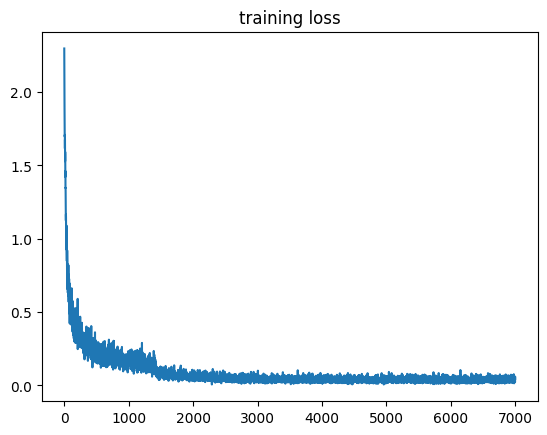

In [87]:
log_interval = 20
n_epoch = 100

pbar_update = 1 / (len(train_loader) + len(test_loader))
losses = []

# The transform needs to live on the same device as the model and the data.
transform = transform.to(device)
with tqdm(total=n_epoch) as pbar:
    for epoch in range(1, n_epoch + 1):
        train(model, epoch, log_interval)
        test(model, epoch)
        scheduler.step()

# Let's plot the training loss versus the number of iteration.
plt.plot(losses);
plt.title("training loss");

# Save model

In [88]:
file = "model_state_dict_2500"
torch.save(model, file)

In [89]:
file = "scripted_model_2500.pt"
model_scripted = torch.jit.script(model) # Export to TorchScript
model_scripted.save(file) # Save

In [90]:
def predict(tensor):
    # Use the model to predict the label of the waveform
    tensor = tensor.to(device)
    tensor = transform(tensor)
    tensor = model(tensor.unsqueeze(0))
    tensor = get_likely_index(tensor)
    tensor = index_to_label(tensor.squeeze())
    return tensor


waveform, sample_rate, utterance, *_ = train_set[2]
ipd.Audio(waveform.numpy(), rate=sample_rate)

print(f"Expected: {utterance}. Predicted: {predict(waveform)}.")

Expected: backward. Predicted: backward.


In [91]:
waveform, *_ = test_set[500]
ipd.Audio(waveform.numpy(), rate=sample_rate)

In [92]:
predict(waveform)

'backward'

In [93]:
myfile = "2023-05-19-16-37-43.mp3"
ipd.Audio(myfile)

In [94]:
metadata = torchaudio.info(myfile)
print(metadata)

AudioMetaData(sample_rate=44100, num_frames=114048, num_channels=2, bits_per_sample=0, encoding=MP3)


In [144]:
waveform, sample_rate = torchaudio.load(myfile)

In [145]:
def plot_waveform(waveform, sample_rate):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sample_rate

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].plot(time_axis, waveform[c], linewidth=1)
        axes[c].grid(True)
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
    figure.suptitle("waveform")
    plt.show(block=False)

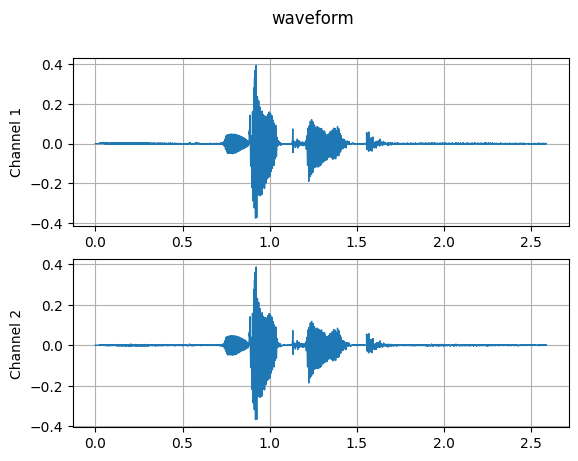

In [146]:
plot_waveform(waveform, sample_rate)

In [147]:
ipd.Audio(waveform.numpy()[0], rate=sample_rate)

In [148]:
waveform.size()

torch.Size([2, 114048])

In [149]:
my_transform = torchaudio.transforms.Resample(orig_freq=114048, new_freq=2500)
waveform_t = my_transform(waveform)

ipd.Audio(waveform_t.numpy()[0], rate=16000)

In [138]:
torch.unsqueeze(torch.unsqueeze(waveform[0], 0), 0).shape

torch.Size([1, 1, 2500])

In [139]:
waveform.shape

torch.Size([2, 2500])

In [124]:
predict(torch.unsqueeze(torch.unsqueeze(waveform[0].to(device), 0), 0))

RuntimeError: Expected 2D (unbatched) or 3D (batched) input to conv1d, but got input of size: [1, 1, 1, 1250]